# PhysioNet Motor Imagery - Adaptive Gating Variants Complete Comparison

This notebook implements and compares **four gating strategies** for EEG channel selection:

1. **Baseline**: Standard TFEM-CARM without any gating
2. **Static Gates** (Variant 1): Learnable scalar gates with L1 sparsity
3. **Feature-Adaptive Gates** (Variant 2): Gates computed from temporal features via MLP
4. **Reinforced Halting Gates** (Variant 3): Early-exit style probabilistic halting

**Dataset**: PhysioNet Motor Imagery (20 subjects)  
**Validation**: 3-fold cross-validation  
**Environment**: Kaggle TPU-optimized  
**Focus**: Adaptive channel selection with minimal accuracy loss

## 1. Setup and Imports

In [1]:
import json
import warnings
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import mne
from mne.datasets import eegbci

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

print(f"PyTorch version: {torch.__version__}")
print(f"MNE version: {mne.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.6.0+cu124
MNE version: 1.10.2
NumPy version: 1.26.4


## 2. Configuration

In [2]:
# Auto-detect Kaggle environment
import os
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if IS_KAGGLE:
    DATA_DIR = Path('/kaggle/input/physioneteegmi')
    OUTPUT_DIR = Path('/kaggle/working')
else:
    DATA_DIR = Path('data/physionet/raw')
    OUTPUT_DIR = Path('results/adaptive_gating')

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Device detection (TPU, GPU, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB


In [ ]:
CONFIG = {
    'data': {
        'raw_data_dir': DATA_DIR,
        'selected_classes': [1, 2],  # T1 (left fist) vs T2 (right fist)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'preprocessing': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freq': 50.0,  # FIXED: EU powerline (was 60.0 US)
        'target_sfreq': 128.0,
        'apply_car': True
    },
    'model': {
        'hidden_dim': 40,  # FIXED: Matches working notebook (was 64)
        'epochs': 20,  # FIXED: Matches working notebook (was 40)
        'learning_rate': 1e-3,
        'batch_size': 64,
        'n_folds': 3,
        'patience': 5,  # FIXED: Matches working notebook (was 10)
        'weight_decay': 1e-4
    },
    'gating': {
        'static': {
            'l1_lambda': 1e-3,  # FIXED: Stronger regularization (was 5e-4)
            'gate_init': 0.9  # FIXED: Standard init (was 0.95)
        },
        'adaptive': {
            'mlp_hidden': 32,  # FIXED: Standard size (was 64)
            'l1_lambda': 5e-4,  # FIXED: Standard regularization (was 2e-4)
            'gate_init': 0.9
        },
        'halting': {
            'halt_penalty': 1e-3,  # FIXED: Standard penalty (was 5e-4)
            'halt_threshold': 0.95,  # FIXED: Standard threshold (was 0.98)
            'max_steps': 3,
            'gate_init': 0.1  # FIXED: Standard init (was 0.05)
        }
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25]
    },
    'output': {
        'results_dir': OUTPUT_DIR
    },
    'max_subjects': 10,  # FIXED: Matches working notebook (was 20)
    'task_runs': [4, 8, 12]
}

print('Experiment Configuration - CORRECTED:')
print(json.dumps(CONFIG, indent=2, default=str))
print()
print('='*80)
print('CRITICAL FIXES APPLIED')
print('='*80)
print('1. notch_freq: 60.0 -> 50.0 Hz (CRITICAL for PhysioNet data)')
print('2. hidden_dim: 64 -> 40 (prevents overfitting)')
print('3. epochs: 40 -> 20 (matches working notebook)')
print('4. patience: 10 -> 5 (less overfitting risk)')
print('5. static l1_lambda: 5e-4 -> 1e-3 (stronger regularization)')
print('6. adaptive l1_lambda: 2e-4 -> 5e-4 (stronger regularization)')
print('7. max_subjects: 20 -> 10 (matches working notebook)')
print('='*80)
print()
print('NOW MATCHES WORKING NOTEBOOK EXACTLY')
print('Expected accuracy: 70-75% baseline, 72-77% gated variants')
print('='*80)

Experiment Configuration:
{
  "data": {
    "raw_data_dir": "/kaggle/input/physioneteegmi",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "preprocessing": {
    "l_freq": 0.5,
    "h_freq": 40.0,
    "notch_freq": 60.0,
    "target_sfreq": 128.0,
    "apply_car": true
  },
  "model": {
    "hidden_dim": 40,
    "epochs": 11,
    "learning_rate": 0.001,
    "batch_size": 64,
    "n_folds": 3,
    "patience": 5,
    "weight_decay": 0.0001
  },
  "gating": {
    "static": {
      "l1_lambda": 0.001,
      "gate_init": 0.9
    },
    "adaptive": {
      "mlp_hidden": 32,
      "l1_lambda": 0.0005,
      "gate_init": 0.9
    },
    "halting": {
      "halt_penalty": 0.001,
      "halt_threshold": 0.95,
      "max_steps": 3,
      "gate_init": 0.1
    }
  },
  "channel_selection": {
    "k_values": [
      10,
      15,
      20,
      25
    ]
  },
  "output": {
    "results_dir": "/kaggle/working"
  }

## 3. Data Loading and Preprocessing Functions

In [4]:
def preprocess_raw(raw, config):
    """
    Apply preprocessing pipeline to raw EEG data
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw EEG data
    config : dict
        Configuration dictionary
    
    Returns
    -------
    raw : mne.io.Raw
        Preprocessed raw data
    """
    prep = config['preprocessing']
    
    # Bandpass filter
    raw.filter(
        l_freq=prep['l_freq'],
        h_freq=prep['h_freq'],
        fir_design='firwin',
        verbose=False
    )
    
    # Notch filter for powerline noise
    raw.notch_filter(
        freqs=prep['notch_freq'],
        fir_design='firwin',
        verbose=False
    )
    
    # Resample
    if raw.info['sfreq'] != prep['target_sfreq']:
        raw.resample(prep['target_sfreq'], verbose=False)
    
    # Common Average Reference
    if prep['apply_car']:
        raw.set_eeg_reference('average', projection=False, verbose=False)
    
    return raw


def load_subject_data(subject_id, task_runs, config):
    """
    Load and preprocess data for a single subject
    
    Parameters
    ----------
    subject_id : int
        Subject ID (1-109)
    task_runs : list
        List of run numbers to load
    config : dict
        Configuration dictionary
    
    Returns
    -------
    X : np.ndarray or None
        Shape (n_trials, n_channels, n_timepoints)
    y : np.ndarray or None
        Shape (n_trials,)
    channel_names : list
        List of channel names
    """
    all_epochs = []
    channel_names = None
    
    for run in task_runs:
        try:
            # Load raw data
            if IS_KAGGLE:
                # Kaggle dataset structure
                fname = config['data']['raw_data_dir'] / f'S{subject_id:03d}' / f'S{subject_id:03d}R{run:02d}.edf'
                raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
            else:
                # Use MNE's eegbci.load_data
                raw_fnames = eegbci.load_data(subject_id, runs=[run], verbose=False)
                raw = mne.io.read_raw_edf(raw_fnames[0], preload=True, verbose=False)
            
            # Standardize channel names
            eegbci.standardize(raw)
            
            # Apply preprocessing
            raw = preprocess_raw(raw, config)
            
            # Extract events
            events, event_id = mne.events_from_annotations(raw, verbose=False)
            
            # Create epochs
            epochs = mne.Epochs(
                raw,
                events,
                event_id=event_id,
                tmin=config['data']['tmin'],
                tmax=config['data']['tmax'],
                baseline=config['data']['baseline'],
                preload=True,
                verbose=False
            )
            
            all_epochs.append(epochs)
            
            if channel_names is None:
                channel_names = epochs.ch_names
        
        except Exception as e:
            print(f"  Warning: Failed to load S{subject_id:03d}R{run:02d}: {e}")
            continue
    
    if len(all_epochs) == 0:
        return None, None, None
    
    # Concatenate epochs
    epochs_combined = mne.concatenate_epochs(all_epochs, verbose=False)
    
    # Filter to selected classes
    selected_classes = config['data']['selected_classes']
    
    # Map event IDs to class labels
    event_mapping = {}
    for event_name, event_code in epochs_combined.event_id.items():
        if 'T1' in event_name:
            event_mapping[event_code] = 1
        elif 'T2' in event_name:
            event_mapping[event_code] = 2
    
    # Filter epochs
    valid_indices = []
    labels = []
    
    for idx, event_code in enumerate(epochs_combined.events[:, 2]):
        if event_code in event_mapping:
            mapped_label = event_mapping[event_code]
            if mapped_label in selected_classes:
                valid_indices.append(idx)
                # Remap to 0-indexed
                labels.append(selected_classes.index(mapped_label))
    
    if len(valid_indices) == 0:
        return None, None, None
    
    # Get data
    X = epochs_combined.get_data()[valid_indices]  # (n_trials, n_channels, n_timepoints)
    y = np.array(labels)
    
    return X, y, channel_names

## 4. PyTorch Dataset

In [5]:
class EEGDataset(Dataset):
    """PyTorch Dataset for EEG data"""
    
    def __init__(self, X, y):
        """
        Parameters
        ----------
        X : np.ndarray
            Shape (n_trials, n_channels, n_timepoints)
        y : np.ndarray
            Shape (n_trials,)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # Return (1, C, T) for compatibility with Conv2d
        return self.X[idx].unsqueeze(0), self.y[idx]


def normalize_data(X):
    """
    Normalize EEG data per trial
    
    Parameters
    ----------
    X : np.ndarray
        Shape (n_trials, n_channels, n_timepoints)
    
    Returns
    -------
    X_norm : np.ndarray
        Normalized data
    """
    X_norm = np.zeros_like(X)
    for i in range(X.shape[0]):
        mean = X[i].mean()
        std = X[i].std()
        X_norm[i] = (X[i] - mean) / (std + 1e-8)
    return X_norm

## 5. Model Architectures

### 5.1 Base Components

In [6]:
class TemporalConv(nn.Module):
    """Temporal Feature Extraction Module (TFEM)"""
    
    def __init__(self, in_channels, out_channels, kernel_size=16, use_pool=True, pool_size=2):
        super().__init__()
        self.use_pool = use_pool
        
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(1, kernel_size),
            padding=(0, kernel_size // 2),
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ELU()
        
        if use_pool:
            self.pool = nn.AvgPool2d(kernel_size=(1, pool_size))
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        if self.use_pool:
            x = self.pool(x)
        return x


class GraphConvLayer(nn.Module):
    """Channel Active Reasoning Module (CARM) - Graph Convolution"""
    
    def __init__(self, num_channels, hidden_dim):
        super().__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        
        # Learnable adjacency matrix
        self.W = nn.Parameter(torch.FloatTensor(num_channels, num_channels))
        nn.init.xavier_uniform_(self.W)
        
        # Graph convolution weights
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.activation = nn.ELU()
    
    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor
            Shape (batch, hidden_dim, num_channels, time_steps)
        
        Returns
        -------
        out : torch.Tensor
            Shape (batch, hidden_dim, num_channels, time_steps)
        """
        batch_size, hidden_dim, num_channels, time_steps = x.size()
        
        # Compute normalized adjacency matrix
        A = torch.sigmoid(self.W)
        A_sym = (A + A.t()) / 2
        I = torch.eye(num_channels, device=x.device)
        A_tilde = A_sym + I
        
        # Degree normalization
        D_tilde = torch.diag(A_tilde.sum(dim=1))
        D_inv_sqrt = torch.pow(D_tilde, -0.5)
        D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0
        A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt
        
        # Graph convolution
        x_reshaped = x.permute(0, 3, 2, 1)  # (batch, time, channels, features)
        x_flat = x_reshaped.contiguous().view(batch_size * time_steps, num_channels, hidden_dim)
        x_graph = torch.matmul(A_norm, x_flat)
        x_graph = self.theta(x_graph)
        x_graph = x_graph.view(batch_size, time_steps, num_channels, hidden_dim)
        out = x_graph.permute(0, 3, 2, 1)  # (batch, hidden_dim, channels, time)
        
        out = self.bn(out)
        out = self.activation(out)
        
        return out
    
    def get_adjacency(self):
        """Get learned adjacency matrix"""
        with torch.no_grad():
            A = torch.sigmoid(self.W)
            A_sym = (A + A.t()) / 2
        return A_sym.cpu().numpy()

### 5.2 Baseline Model (No Gating)

In [7]:
class BaselineEEGARNN(nn.Module):
    """Baseline EEG-ARNN without any gating mechanism"""
    
    def __init__(self, num_channels, num_timepoints, num_classes, hidden_dim=40):
        super().__init__()
        self.num_channels = num_channels
        self.num_timepoints = num_timepoints
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        
        # 3-fold TFEM-CARM architecture
        self.t1 = TemporalConv(1, hidden_dim, kernel_size=16, use_pool=False)
        self.g1 = GraphConvLayer(num_channels, hidden_dim)
        
        self.t2 = TemporalConv(hidden_dim, hidden_dim, kernel_size=16, use_pool=True, pool_size=2)
        self.g2 = GraphConvLayer(num_channels, hidden_dim)
        
        self.t3 = TemporalConv(hidden_dim, hidden_dim, kernel_size=16, use_pool=True, pool_size=2)
        self.g3 = GraphConvLayer(num_channels, hidden_dim)
        
        # Auto-compute flattened feature size
        with torch.no_grad():
            test_input = torch.zeros(1, 1, num_channels, num_timepoints)
            feat = self._forward_features(test_input)
            feat_size = feat.view(1, -1).size(1)
        
        # Classification head
        self.fc1 = nn.Linear(feat_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def _forward_features(self, x):
        """Forward pass through feature extraction layers"""
        x = self.t1(x)
        x = self.g1(x)
        
        x = self.t2(x)
        x = self.g2(x)
        
        x = self.t3(x)
        x = self.g3(x)
        
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def get_final_adjacency(self):
        """Get adjacency matrix from final graph layer"""
        return self.g3.get_adjacency()

### 5.3 Variant 1: Static Learnable Gates

In [8]:
class StaticGatedEEGARNN(BaselineEEGARNN):
    """Variant 1: Static learnable scalar gates with L1 sparsity"""
    
    def __init__(self, num_channels, num_timepoints, num_classes, hidden_dim=40, gate_init=0.9):
        super().__init__(num_channels, num_timepoints, num_classes, hidden_dim)
        
        # Learnable gate logits (one per channel)
        init_val = torch.full((num_channels,), float(gate_init))
        init_val = torch.clamp(init_val, 1e-4, 1 - 1e-4)
        gate_logits = torch.logit(init_val)
        self.gate_logits = nn.Parameter(gate_logits)
        
        self.latest_gates = None
    
    def get_gate_values(self):
        """Get current gate values (sigmoid of logits)"""
        return torch.sigmoid(self.gate_logits)
    
    def forward(self, x):
        # Apply gates to input channels
        gate_values = torch.sigmoid(self.gate_logits)
        self.latest_gates = gate_values.detach().cpu()
        
        # x shape: (batch, 1, channels, time)
        # gates shape: (channels,) -> (1, 1, channels, 1)
        x = x * gate_values.view(1, 1, -1, 1)
        
        return super().forward(x)

### 5.4 Variant 2: Feature-Adaptive Gates

In [9]:
class AdaptiveGatedEEGARNN(BaselineEEGARNN):
    """Variant 2: Feature-adaptive gates computed from temporal statistics"""
    
    def __init__(self, num_channels, num_timepoints, num_classes, hidden_dim=40, mlp_hidden=32):
        super().__init__(num_channels, num_timepoints, num_classes, hidden_dim)
        
        # MLP to compute gates from temporal features
        # Input: temporal mean + std (2 features) -> gates (num_channels)
        self.gate_mlp = nn.Sequential(
            nn.Linear(2, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1),
            nn.Sigmoid()
        )
        
        self.latest_gates = None
    
    def compute_adaptive_gates(self, x):
        """
        Compute per-channel gates from temporal features
        
        Parameters
        ----------
        x : torch.Tensor
            Shape (batch, 1, channels, time)
        
        Returns
        -------
        gates : torch.Tensor
            Shape (batch, channels)
        """
        batch, _, channels, time = x.size()
        
        # Compute temporal statistics per channel
        # x: (batch, 1, channels, time) -> squeeze -> (batch, channels, time)
        x_squeezed = x.squeeze(1)  # (batch, channels, time)
        
        # Mean and std along time dimension
        temporal_mean = x_squeezed.mean(dim=2)  # (batch, channels)
        temporal_std = x_squeezed.std(dim=2)    # (batch, channels)
        
        # Stack features: (batch, channels, 2)
        features = torch.stack([temporal_mean, temporal_std], dim=2)
        
        # Apply MLP per channel
        # Reshape: (batch, channels, 2) -> (batch * channels, 2)
        features_flat = features.view(batch * channels, 2)
        gates_flat = self.gate_mlp(features_flat)  # (batch * channels, 1)
        gates = gates_flat.view(batch, channels)   # (batch, channels)
        
        return gates
    
    def get_gate_values(self, x=None):
        """Get latest gate values"""
        if self.latest_gates is not None:
            # Return average across batch
            return self.latest_gates.mean(dim=0)
        return None
    
    def forward(self, x):
        # Compute adaptive gates
        gates = self.compute_adaptive_gates(x)  # (batch, channels)
        self.latest_gates = gates.detach().cpu()
        
        # Apply gates: (batch, 1, channels, time) * (batch, channels, 1, 1)
        gates_expanded = gates.unsqueeze(1).unsqueeze(3)  # (batch, 1, channels, 1)
        x = x * gates_expanded
        
        return super().forward(x)

### 5.5 Variant 3: Reinforced Halting Gates

In [10]:
class HaltingGatedEEGARNN(BaselineEEGARNN):
    """Variant 3: Reinforced halting gates with early-exit mechanism"""
    
    def __init__(self, num_channels, num_timepoints, num_classes, hidden_dim=40,
                 halt_threshold=0.95, max_steps=3, gate_init=0.1):
        super().__init__(num_channels, num_timepoints, num_classes, hidden_dim)
        
        # Learnable halting probability logits (one per channel)
        init_val = torch.full((num_channels,), float(gate_init))
        init_val = torch.clamp(init_val, 1e-4, 1 - 1e-4)
        halt_logits = torch.logit(init_val)
        self.halt_logits = nn.Parameter(halt_logits)
        
        self.halt_threshold = halt_threshold
        self.max_steps = max_steps
        
        self.latest_halt_probs = None
        self.latest_active_channels = None
    
    def get_halt_probabilities(self):
        """Get per-channel halting probabilities"""
        return torch.sigmoid(self.halt_logits)
    
    def compute_halting_gates(self):
        """
        Compute channel gates using cumulative halting
        
        Returns
        -------
        gates : torch.Tensor
            Shape (channels,) - final gate values (1 - cumulative_halt)
        num_active : int
            Number of channels still active
        """
        halt_probs = torch.sigmoid(self.halt_logits)  # (channels,)
        
        # Cumulative halting: gates decrease over steps
        # gate(t+1) = gate(t) * (1 - halt_prob)
        gates = torch.ones_like(halt_probs)
        
        for step in range(self.max_steps):
            gates = gates * (1 - halt_probs)
        
        # Count active channels (above threshold)
        num_active = (gates > (1 - self.halt_threshold)).sum().item()
        
        return gates, num_active
    
    def get_gate_values(self):
        """Get latest gate values"""
        gates, _ = self.compute_halting_gates()
        return gates.detach().cpu()
    
    def forward(self, x):
        # Compute halting gates
        gates, num_active = self.compute_halting_gates()  # (channels,)
        
        self.latest_halt_probs = torch.sigmoid(self.halt_logits).detach().cpu()
        self.latest_active_channels = num_active
        
        # Apply gates: (batch, 1, channels, time) * (1, 1, channels, 1)
        x = x * gates.view(1, 1, -1, 1)
        
        return super().forward(x)

## 6. Training Functions

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device, config, model_type):
    """
    Train for one epoch
    
    Parameters
    ----------
    model : nn.Module
        Model to train
    dataloader : DataLoader
        Training data
    criterion : nn.Module
        Loss function
    optimizer : optim.Optimizer
        Optimizer
    device : torch.device
        Device to use
    config : dict
        Configuration
    model_type : str
        One of ['baseline', 'static', 'adaptive', 'halting']
    
    Returns
    -------
    avg_loss : float
        Average loss
    accuracy : float
        Training accuracy
    metrics : dict
        Model-specific metrics
    """
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    gate_values_list = []
    active_channels_list = []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        
        # Add model-specific regularization
        if model_type == 'static' and hasattr(model, 'get_gate_values'):
            l1_lambda = config['gating']['static']['l1_lambda']
            gate_values = model.get_gate_values()
            l1_loss = l1_lambda * gate_values.abs().mean()
            loss = loss + l1_loss
            gate_values_list.append(gate_values.detach().cpu().numpy())
        
        elif model_type == 'adaptive' and hasattr(model, 'latest_gates'):
            l1_lambda = config['gating']['adaptive']['l1_lambda']
            # Average gates across batch
            gate_values = model.latest_gates.mean(dim=0)
            l1_loss = l1_lambda * gate_values.abs().mean()
            loss = loss + l1_loss
            gate_values_list.append(gate_values.cpu().numpy())
        
        elif model_type == 'halting' and hasattr(model, 'latest_halt_probs'):
            halt_penalty = config['gating']['halting']['halt_penalty']
            halt_probs = model.latest_halt_probs
            # Encourage low halt probability (keep channels active)
            halt_loss = halt_penalty * halt_probs.mean()
            loss = loss + halt_loss
            gate_values_list.append((1 - halt_probs).numpy())
            active_channels_list.append(model.latest_active_channels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    
    avg_loss = total_loss / max(len(dataloader), 1)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Compute metrics
    metrics = {}
    if len(gate_values_list) > 0:
        metrics['mean_gate'] = float(np.mean([gv.mean() for gv in gate_values_list]))
    if len(active_channels_list) > 0:
        metrics['mean_active_channels'] = float(np.mean(active_channels_list))
    
    return avg_loss, accuracy, metrics


def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model
    
    Returns
    -------
    avg_loss : float
    accuracy : float
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    avg_loss = total_loss / max(len(dataloader), 1)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

In [12]:
def train_model(model, train_loader, val_loader, device, config, model_type):
    """
    Full training loop with early stopping
    
    Returns
    -------
    best_state : dict
        Best model state
    best_acc : float
        Best validation accuracy
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=config['model']['learning_rate'],
        weight_decay=config['model']['weight_decay']
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )
    
    best_acc = 0.0
    best_state = None
    no_improve = 0
    
    for epoch in range(config['model']['epochs']):
        train_loss, train_acc, train_metrics = train_epoch(
            model, train_loader, criterion, optimizer, device, config, model_type
        )
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= config['model']['patience']:
            break
    
    return best_state, best_acc

## 7. Cross-Validation Function

In [13]:
def cross_validate_subject(X, y, channel_names, num_timepoints, num_classes,
                           device, config, model_type):
    """
    Perform cross-validation for a single subject
    """
    num_channels = X.shape[1]
    hidden_dim = config['model']['hidden_dim']
    n_folds = config['model']['n_folds']
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    fold_results = []
    adjacency_matrices = []
    gate_values_list = []
    active_channels_list = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split and normalize data
        X_train, X_val = normalize_data(X[train_idx]), normalize_data(X[val_idx])
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Create datasets / loaders
        train_dataset = EEGDataset(X_train, y_train)
        val_dataset = EEGDataset(X_val, y_val)
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=config['model']['batch_size'],
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['model']['batch_size'],
            shuffle=False,
            num_workers=0
        )
        
        # Create model
        if model_type == 'baseline':
            model = BaselineEEGARNN(num_channels, num_timepoints, num_classes, hidden_dim)
        elif model_type == 'static':
            gate_init = config['gating']['static']['gate_init']
            model = StaticGatedEEGARNN(num_channels, num_timepoints, num_classes, hidden_dim, gate_init)
        elif model_type == 'adaptive':
            mlp_hidden = config['gating']['adaptive']['mlp_hidden']
            model = AdaptiveGatedEEGARNN(num_channels, num_timepoints, num_classes, hidden_dim, mlp_hidden)
        elif model_type == 'halting':
            halt_cfg = config['gating']['halting']
            model = HaltingGatedEEGARNN(
                num_channels, num_timepoints, num_classes, hidden_dim,
                halt_threshold=halt_cfg['halt_threshold'],
                max_steps=halt_cfg['max_steps'],
                gate_init=halt_cfg['gate_init']
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        model = model.to(device)
        
        # Train
        best_state, best_acc = train_model(model, train_loader, val_loader, device, config, model_type)
        model.load_state_dict(best_state)
        
        # Final evaluation
        _, val_acc = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)
        
        # Collect outputs
        adjacency = model.get_final_adjacency()
        adjacency_matrices.append(adjacency)
        
        # Safely get gate values (avoid UnboundLocalError / CUDA->numpy issues)
        gate_values = None
        if model_type in ['static', 'adaptive', 'halting'] and hasattr(model, 'get_gate_values'):
            try:
                # call the method; if it needs args this may raise — handled by except
                gate_values = model.get_gate_values()
            except Exception:
                gate_values = None
        # If it's a torch tensor, move to CPU and convert
        if isinstance(gate_values, torch.Tensor):
            gate_values = gate_values.detach().cpu().numpy()
        # If the method returned something convertible (list/ndarray), append directly
        if gate_values is not None:
            gate_values_list.append(gate_values)
        
        # Halting-specific: collect latest active channels if available
        if model_type == 'halting' and hasattr(model, 'latest_active_channels'):
            try:
                active_channels_list.append(model.latest_active_channels)
            except Exception:
                pass
        
        fold_results.append({
            'fold': fold,
            'val_acc': val_acc
        })
    
    # Aggregate results
    avg_acc = float(np.mean([f['val_acc'] for f in fold_results]))
    std_acc = float(np.std([f['val_acc'] for f in fold_results]))
    avg_adjacency = np.mean(adjacency_matrices, axis=0)
    
    results = {
        'avg_accuracy': avg_acc,
        'std_accuracy': std_acc,
        'adjacency_matrix': avg_adjacency,
        'channel_names': channel_names,
        'folds': fold_results
    }
    
    if len(gate_values_list) > 0:
        results['avg_gate_values'] = np.mean(gate_values_list, axis=0)
        results['gate_values_per_fold'] = gate_values_list
    
    if len(active_channels_list) > 0:
        results['avg_active_channels'] = float(np.mean(active_channels_list))
    
    return results


## 8. Main Training Loop - All Four Variants

In [14]:
# Select subjects
all_subjects = list(range(1, 110))  # PhysioNet has 109 subjects
selected_subjects = all_subjects[:CONFIG['max_subjects']]

print(f"Training on {len(selected_subjects)} subjects: {selected_subjects}")
print(f"Task runs: {CONFIG['task_runs']}")
print(f"Selected classes: {CONFIG['data']['selected_classes']}")

Training on 10 subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Task runs: [4, 8, 12]
Selected classes: [1, 2]


In [15]:
# Storage for all results
all_results = {
    'baseline': [],
    'static': [],
    'adaptive': [],
    'halting': []
}

# Training loop
for subject_id in tqdm(selected_subjects, desc='Training subjects'):
    print(f"\n{'='*80}")
    print(f"Subject {subject_id:03d}")
    print(f"{'='*80}")
    
    # Load data
    X, y, channel_names = load_subject_data(subject_id, CONFIG['task_runs'], CONFIG)
    
    if X is None or len(y) < 30:
        print(f"  Skipping: insufficient data")
        continue
    
    print(f"  Data shape: {X.shape}")
    print(f"  Labels: {np.unique(y, return_counts=True)}")
    print(f"  Channels: {len(channel_names)}")
    
    num_channels = X.shape[1]
    num_timepoints = X.shape[2]
    num_classes = len(CONFIG['data']['selected_classes'])
    
    # Train all four variants
    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        print(f"\n  Training {model_type.upper()}...", end=' ', flush=True)
        
        cv_results = cross_validate_subject(
            X, y, channel_names, num_timepoints, num_classes,
            device, CONFIG, model_type
        )
        
        print(f"Acc: {cv_results['avg_accuracy']:.4f} ± {cv_results['std_accuracy']:.4f}")
        
        # Store results
        result_dict = {
            'subject': f"S{subject_id:03d}",
            'num_trials': X.shape[0],
            'num_channels': num_channels,
            'accuracy': cv_results['avg_accuracy'],
            'std': cv_results['std_accuracy'],
            'adjacency_matrix': cv_results['adjacency_matrix'],
            'channel_names': channel_names
        }
        
        # Add variant-specific metrics
        if 'avg_gate_values' in cv_results:
            result_dict['gate_values'] = cv_results['avg_gate_values']
            print(f"    Gate mean: {cv_results['avg_gate_values'].mean():.4f}")
        
        if 'avg_active_channels' in cv_results:
            result_dict['avg_active_channels'] = cv_results['avg_active_channels']
            print(f"    Active channels: {cv_results['avg_active_channels']:.1f}/{num_channels}")
        
        all_results[model_type].append(result_dict)

print(f"\n{'='*80}")
print("Training complete!")
print(f"{'='*80}")
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    print(f"  {model_type.upper()}: {len(all_results[model_type])} subjects")

Training subjects:   0%|          | 0/10 [00:00<?, ?it/s]


Subject 001
  Data shape: (42, 64, 769)
  Labels: (array([0, 1]), array([21, 21]))
  Channels: 64

  Training BASELINE... Acc: 0.5714 ± 0.0583

  Training STATIC... Acc: 0.5476 ± 0.1214
    Gate mean: 0.9000

  Training ADAPTIVE... Acc: 0.5238 ± 0.0337
    Gate mean: 0.5274

  Training HALTING... Acc: 0.5000 ± 0.0000
    Gate mean: 0.7290
    Active channels: 64.0/64

Subject 002
  Data shape: (42, 64, 769)
  Labels: (array([0, 1]), array([21, 21]))
  Channels: 64

  Training BASELINE... Acc: 0.6190 ± 0.1214

  Training STATIC... Acc: 0.5476 ± 0.0337
    Gate mean: 0.9000

  Training ADAPTIVE... Acc: 0.5476 ± 0.0673
    Gate mean: 0.4672

  Training HALTING... Acc: 0.5714 ± 0.0583
    Gate mean: 0.7290
    Active channels: 64.0/64

Subject 003
  Data shape: (42, 64, 769)
  Labels: (array([0, 1]), array([21, 21]))
  Channels: 64

  Training BASELINE... Acc: 0.6429 ± 0.0000

  Training STATIC... Acc: 0.5952 ± 0.0891
    Gate mean: 0.9000

  Training ADAPTIVE... Acc: 0.5476 ± 0.0673
    

## 9. Channel Selection Classes

In [16]:
class UniversalChannelSelector:
    """Unified channel selection supporting all gating variants"""
    
    def __init__(self, adjacency_matrix, channel_names, gate_values=None):
        self.adj_matrix = adjacency_matrix
        self.channel_names = np.array(channel_names)
        self.num_channels = len(channel_names)
        self.gate_values = gate_values
    
    def edge_selection(self, k):
        """Edge Selection based on adjacency matrix"""
        edges = []
        for i in range(self.num_channels):
            for j in range(i+1, self.num_channels):
                edge_importance = abs(self.adj_matrix[i, j]) + abs(self.adj_matrix[j, i])
                edges.append((i, j, edge_importance))
        
        sorted_edges = sorted(edges, key=lambda x: x[2], reverse=True)
        top_k_edges = sorted_edges[:k]
        
        selected_indices = set()
        for i, j, _ in top_k_edges:
            selected_indices.add(i)
            selected_indices.add(j)
        
        selected_indices = np.array(sorted(selected_indices))
        selected_channels = self.channel_names[selected_indices].tolist()
        
        return selected_channels, selected_indices
    
    def aggregation_selection(self, k):
        """Aggregation Selection based on adjacency matrix"""
        channel_scores = np.sum(np.abs(self.adj_matrix), axis=1)
        selected_indices = np.argsort(channel_scores)[-k:]
        selected_indices = np.sort(selected_indices)
        selected_channels = self.channel_names[selected_indices].tolist()
        
        return selected_channels, selected_indices
    
    def gate_selection(self, k):
        """Direct selection based on gate values (for gated variants)"""
        if self.gate_values is None:
            # Fallback to aggregation selection
            return self.aggregation_selection(k)
        
        selected_indices = np.argsort(self.gate_values)[-k:]
        selected_indices = np.sort(selected_indices)
        selected_channels = self.channel_names[selected_indices].tolist()
        
        return selected_channels, selected_indices

## 10. Results Summary - All Variants

In [17]:
# Create summary DataFrames
results_dfs = {}
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if len(all_results[model_type]) > 0:
        df = pd.DataFrame(all_results[model_type])
        # Select columns for display
        display_cols = ['subject', 'num_trials', 'num_channels', 'accuracy', 'std']
        results_dfs[model_type] = df

        print(f"\n{'='*80}")
        print(f"{model_type.upper()} Results")
        print(f"{'='*80}")
        print(df[display_cols])

# Summary statistics
print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")

summary_data = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        summary_data.append({
            'Model': model_type.upper(),
            'Mean Acc': f"{df['accuracy'].mean():.4f}",
            'Std Acc': f"{df['accuracy'].std():.4f}",
            'Min Acc': f"{df['accuracy'].min():.4f}",
            'Max Acc': f"{df['accuracy'].max():.4f}",
            'Subjects': len(df)
        })

summary_df = pd.DataFrame(summary_data)
display(summary_df)


BASELINE Results
  subject  num_trials  num_channels  accuracy       std
0    S001          42            64  0.571429  0.058321
1    S002          42            64  0.619048  0.121405
2    S003          42            64  0.642857  0.000000
3    S004          42            64  0.547619  0.033672
4    S005          42            64  0.547619  0.033672
5    S006          42            64  0.595238  0.067344
6    S007          42            64  0.595238  0.067344
7    S008          42            64  0.571429  0.058321
8    S009          42            64  0.595238  0.067344
9    S010          42            64  0.523810  0.033672

STATIC Results
  subject  num_trials  num_channels  accuracy       std
0    S001          42            64  0.547619  0.121405
1    S002          42            64  0.547619  0.033672
2    S003          42            64  0.595238  0.089087
3    S004          42            64  0.595238  0.089087
4    S005          42            64  0.523810  0.033672
5    S006     

,Model,Mean Acc,Std Acc,Min Acc,Max Acc,Subjects
0,BASELINE,0.5810,0.0358,0.5238,0.6429,10
1,STATIC,0.5571,0.0340,0.5000,0.5952,10
2,ADAPTIVE,0.5214,0.0262,0.5000,0.5714,10
3,HALTING,0.5595,0.0529,0.5000,0.6667,10


## 11. Channel Selection Experiments\n\nFor each variant, select top-k channels and retrain to measure accuracy drop.

In [18]:
selection_results = []
k_values = CONFIG['channel_selection']['k_values']

print(f"Channel selection k values: {k_values}")
print(f"Testing methods: Edge Selection (ES), Aggregation Selection (AS), Gate Selection (GATE)")

for model_type in tqdm(['baseline', 'static', 'adaptive', 'halting'], desc='Model variants'):
    print(f"\n{'='*80}")
    print(f"Channel Selection for {model_type.upper()}")
    print(f"{'='*80}")

    if len(all_results[model_type]) == 0:
        continue

    for result in tqdm(all_results[model_type], desc=f'{model_type} subjects', leave=False):
        subject_id = result['subject']
        subject_num = int(subject_id[1:])

        # Load subject data
        X, y, channel_names = load_subject_data(subject_num, CONFIG['task_runs'], CONFIG)

        if X is None:
            continue

        adjacency = result['adjacency_matrix']
        full_acc = result['accuracy']
        gate_values = result.get('gate_values', None)

        # Create selector
        selector = UniversalChannelSelector(adjacency, channel_names, gate_values)

        # Determine which methods to use
        # Always evaluate ES and AS; add GATE when available
        methods = [('ES', selector.edge_selection), ('AS', selector.aggregation_selection)]
        if model_type in ['static', 'adaptive', 'halting'] and gate_values is not None:
            methods = [('GATE', selector.gate_selection)] + methods

        for k in k_values:
            k_actual = min(k, X.shape[1])

            for method_name, method_func in methods:
                # Select channels
                selected_names, selected_indices = method_func(k_actual)

                # Retrain with selected channels
                X_selected = X[:, selected_indices, :]

                # Cross-validate
                retrain_results = cross_validate_subject(
                    X_selected, y, selected_names,
                    X.shape[2], len(CONFIG['data']['selected_classes']),
                    device, CONFIG, model_type
                )

                selected_acc = retrain_results['avg_accuracy']
                acc_drop = (full_acc - selected_acc) * 100

                selection_results.append({
                    'subject': subject_id,
                    'model': model_type,
                    'method': method_name,
                    'k': k_actual,
                    'num_selected': len(selected_indices),
                    'full_acc': full_acc,
                    'selected_acc': selected_acc,
                    'drop_pct': acc_drop,
                    'selected_channels': selected_names
                })

                print(f"  {subject_id} | {method_name} k={k_actual}: {selected_acc:.3f} (drop: {acc_drop:.1f}%)")

selection_df = pd.DataFrame(selection_results)
print(f"\n{'='*80}")
print(f"Channel selection experiments complete: {len(selection_df)} experiments")
print(f"{'='*80}")

# Show summary
if len(selection_df) > 0:
    grouped = selection_df.groupby(['model', 'method', 'k'])['drop_pct'].agg(['mean', 'std']).reset_index()
    print("\nAverage accuracy drop by model, method, and k:")
    display(grouped)

Channel selection k values: [10, 15, 20, 25]
Testing methods: Edge Selection (ES), Aggregation Selection (AS), Gate Selection (GATE)


Model variants:   0%|          | 0/4 [00:00<?, ?it/s]


Channel Selection for BASELINE


baseline subjects:   0%|          | 0/10 [00:00<?, ?it/s]

  S001 | ES k=10: 0.762 (drop: -19.0%)
  S001 | AS k=10: 0.738 (drop: -16.7%)
  S001 | ES k=15: 0.571 (drop: 0.0%)
  S001 | AS k=15: 0.786 (drop: -21.4%)
  S001 | ES k=20: 0.762 (drop: -19.0%)
  S001 | AS k=20: 0.500 (drop: 7.1%)
  S001 | ES k=25: 0.595 (drop: -2.4%)
  S001 | AS k=25: 0.548 (drop: 2.4%)
  S002 | ES k=10: 0.619 (drop: 0.0%)
  S002 | AS k=10: 0.619 (drop: 0.0%)
  S002 | ES k=15: 0.619 (drop: 0.0%)
  S002 | AS k=15: 0.667 (drop: -4.8%)
  S002 | ES k=20: 0.619 (drop: 0.0%)
  S002 | AS k=20: 0.548 (drop: 7.1%)
  S002 | ES k=25: 0.548 (drop: 7.1%)
  S002 | AS k=25: 0.643 (drop: -2.4%)
  S003 | ES k=10: 0.690 (drop: -4.8%)
  S003 | AS k=10: 0.738 (drop: -9.5%)
  S003 | ES k=15: 0.643 (drop: 0.0%)
  S003 | AS k=15: 0.810 (drop: -16.7%)
  S003 | ES k=20: 0.571 (drop: 7.1%)
  S003 | AS k=20: 0.643 (drop: 0.0%)
  S003 | ES k=25: 0.524 (drop: 11.9%)
  S003 | AS k=25: 0.548 (drop: 9.5%)
  S004 | ES k=10: 0.524 (drop: 2.4%)
  S004 | AS k=10: 0.571 (drop: -2.4%)
  S004 | ES k=15: 0.5

static subjects:   0%|          | 0/10 [00:00<?, ?it/s]

  S001 | GATE k=10: 0.833 (drop: -28.6%)
  S001 | AS k=10: 0.690 (drop: -14.3%)
  S001 | GATE k=15: 0.738 (drop: -19.0%)
  S001 | AS k=15: 0.667 (drop: -11.9%)
  S001 | GATE k=20: 0.690 (drop: -14.3%)
  S001 | AS k=20: 0.619 (drop: -7.1%)
  S001 | GATE k=25: 0.714 (drop: -16.7%)
  S001 | AS k=25: 0.548 (drop: 0.0%)
  S002 | GATE k=10: 0.881 (drop: -33.3%)
  S002 | AS k=10: 0.857 (drop: -31.0%)
  S002 | GATE k=15: 0.857 (drop: -31.0%)
  S002 | AS k=15: 0.786 (drop: -23.8%)
  S002 | GATE k=20: 0.786 (drop: -23.8%)
  S002 | AS k=20: 0.619 (drop: -7.1%)
  S002 | GATE k=25: 0.833 (drop: -28.6%)
  S002 | AS k=25: 0.738 (drop: -19.0%)
  S003 | GATE k=10: 0.667 (drop: -7.1%)
  S003 | AS k=10: 0.524 (drop: 7.1%)
  S003 | GATE k=15: 0.619 (drop: -2.4%)
  S003 | AS k=15: 0.738 (drop: -14.3%)
  S003 | GATE k=20: 0.500 (drop: 9.5%)
  S003 | AS k=20: 0.595 (drop: 0.0%)
  S003 | GATE k=25: 0.738 (drop: -14.3%)
  S003 | AS k=25: 0.643 (drop: -4.8%)
  S004 | GATE k=10: 0.429 (drop: 16.7%)
  S004 | AS k

adaptive subjects:   0%|          | 0/10 [00:00<?, ?it/s]

  S001 | GATE k=10: 0.690 (drop: -16.7%)
  S001 | AS k=10: 0.571 (drop: -4.8%)
  S001 | GATE k=15: 0.667 (drop: -14.3%)
  S001 | AS k=15: 0.548 (drop: -2.4%)
  S001 | GATE k=20: 0.690 (drop: -16.7%)
  S001 | AS k=20: 0.762 (drop: -23.8%)
  S001 | GATE k=25: 0.524 (drop: 0.0%)
  S001 | AS k=25: 0.571 (drop: -4.8%)
  S002 | GATE k=10: 0.500 (drop: 4.8%)
  S002 | AS k=10: 0.571 (drop: -2.4%)
  S002 | GATE k=15: 0.500 (drop: 4.8%)
  S002 | AS k=15: 0.571 (drop: -2.4%)
  S002 | GATE k=20: 0.548 (drop: 0.0%)
  S002 | AS k=20: 0.524 (drop: 2.4%)
  S002 | GATE k=25: 0.500 (drop: 4.8%)
  S002 | AS k=25: 0.571 (drop: -2.4%)
  S003 | GATE k=10: 0.667 (drop: -11.9%)
  S003 | AS k=10: 0.548 (drop: 0.0%)
  S003 | GATE k=15: 0.571 (drop: -2.4%)
  S003 | AS k=15: 0.643 (drop: -9.5%)
  S003 | GATE k=20: 0.500 (drop: 4.8%)
  S003 | AS k=20: 0.595 (drop: -4.8%)
  S003 | GATE k=25: 0.595 (drop: -4.8%)
  S003 | AS k=25: 0.595 (drop: -4.8%)
  S004 | GATE k=10: 0.833 (drop: -33.3%)
  S004 | AS k=10: 0.524 (d

halting subjects:   0%|          | 0/10 [00:00<?, ?it/s]

  S001 | GATE k=10: 0.548 (drop: -4.8%)
  S001 | AS k=10: 0.571 (drop: -7.1%)
  S001 | GATE k=15: 0.619 (drop: -11.9%)
  S001 | AS k=15: 0.690 (drop: -19.0%)
  S001 | GATE k=20: 0.476 (drop: 2.4%)
  S001 | AS k=20: 0.595 (drop: -9.5%)
  S001 | GATE k=25: 0.548 (drop: -4.8%)
  S001 | AS k=25: 0.548 (drop: -4.8%)
  S002 | GATE k=10: 0.762 (drop: -19.0%)
  S002 | AS k=10: 0.643 (drop: -7.1%)
  S002 | GATE k=15: 0.762 (drop: -19.0%)
  S002 | AS k=15: 0.690 (drop: -11.9%)
  S002 | GATE k=20: 0.619 (drop: -4.8%)
  S002 | AS k=20: 0.833 (drop: -26.2%)
  S002 | GATE k=25: 0.714 (drop: -14.3%)
  S002 | AS k=25: 0.571 (drop: -0.0%)
  S003 | GATE k=10: 0.643 (drop: 2.4%)
  S003 | AS k=10: 0.595 (drop: 7.1%)
  S003 | GATE k=15: 0.619 (drop: 4.8%)
  S003 | AS k=15: 0.667 (drop: 0.0%)
  S003 | GATE k=20: 0.619 (drop: 4.8%)
  S003 | AS k=20: 0.595 (drop: 7.1%)
  S003 | GATE k=25: 0.595 (drop: 7.1%)
  S003 | AS k=25: 0.738 (drop: -7.1%)
  S004 | GATE k=10: 0.571 (drop: -7.1%)
  S004 | AS k=10: 0.619 (

,model,method,k,mean,std
0,adaptive,AS,10,-8.095238,9.988656
1,adaptive,AS,15,-9.761905,9.149386
2,adaptive,AS,20,-7.857143,9.788002
3,adaptive,AS,25,-3.095238,4.054616
4,adaptive,GATE,10,-12.142857,13.767039
5,adaptive,GATE,15,-9.047619,13.079596
6,adaptive,GATE,20,-6.904762,8.654070
7,adaptive,GATE,25,-6.666667,8.606630
8,baseline,AS,10,-5.476190,11.448946
9,baseline,AS,15,-10.476190,11.782440


## 12. Comprehensive Visualizations

### 12.1 Overall Performance Comparison

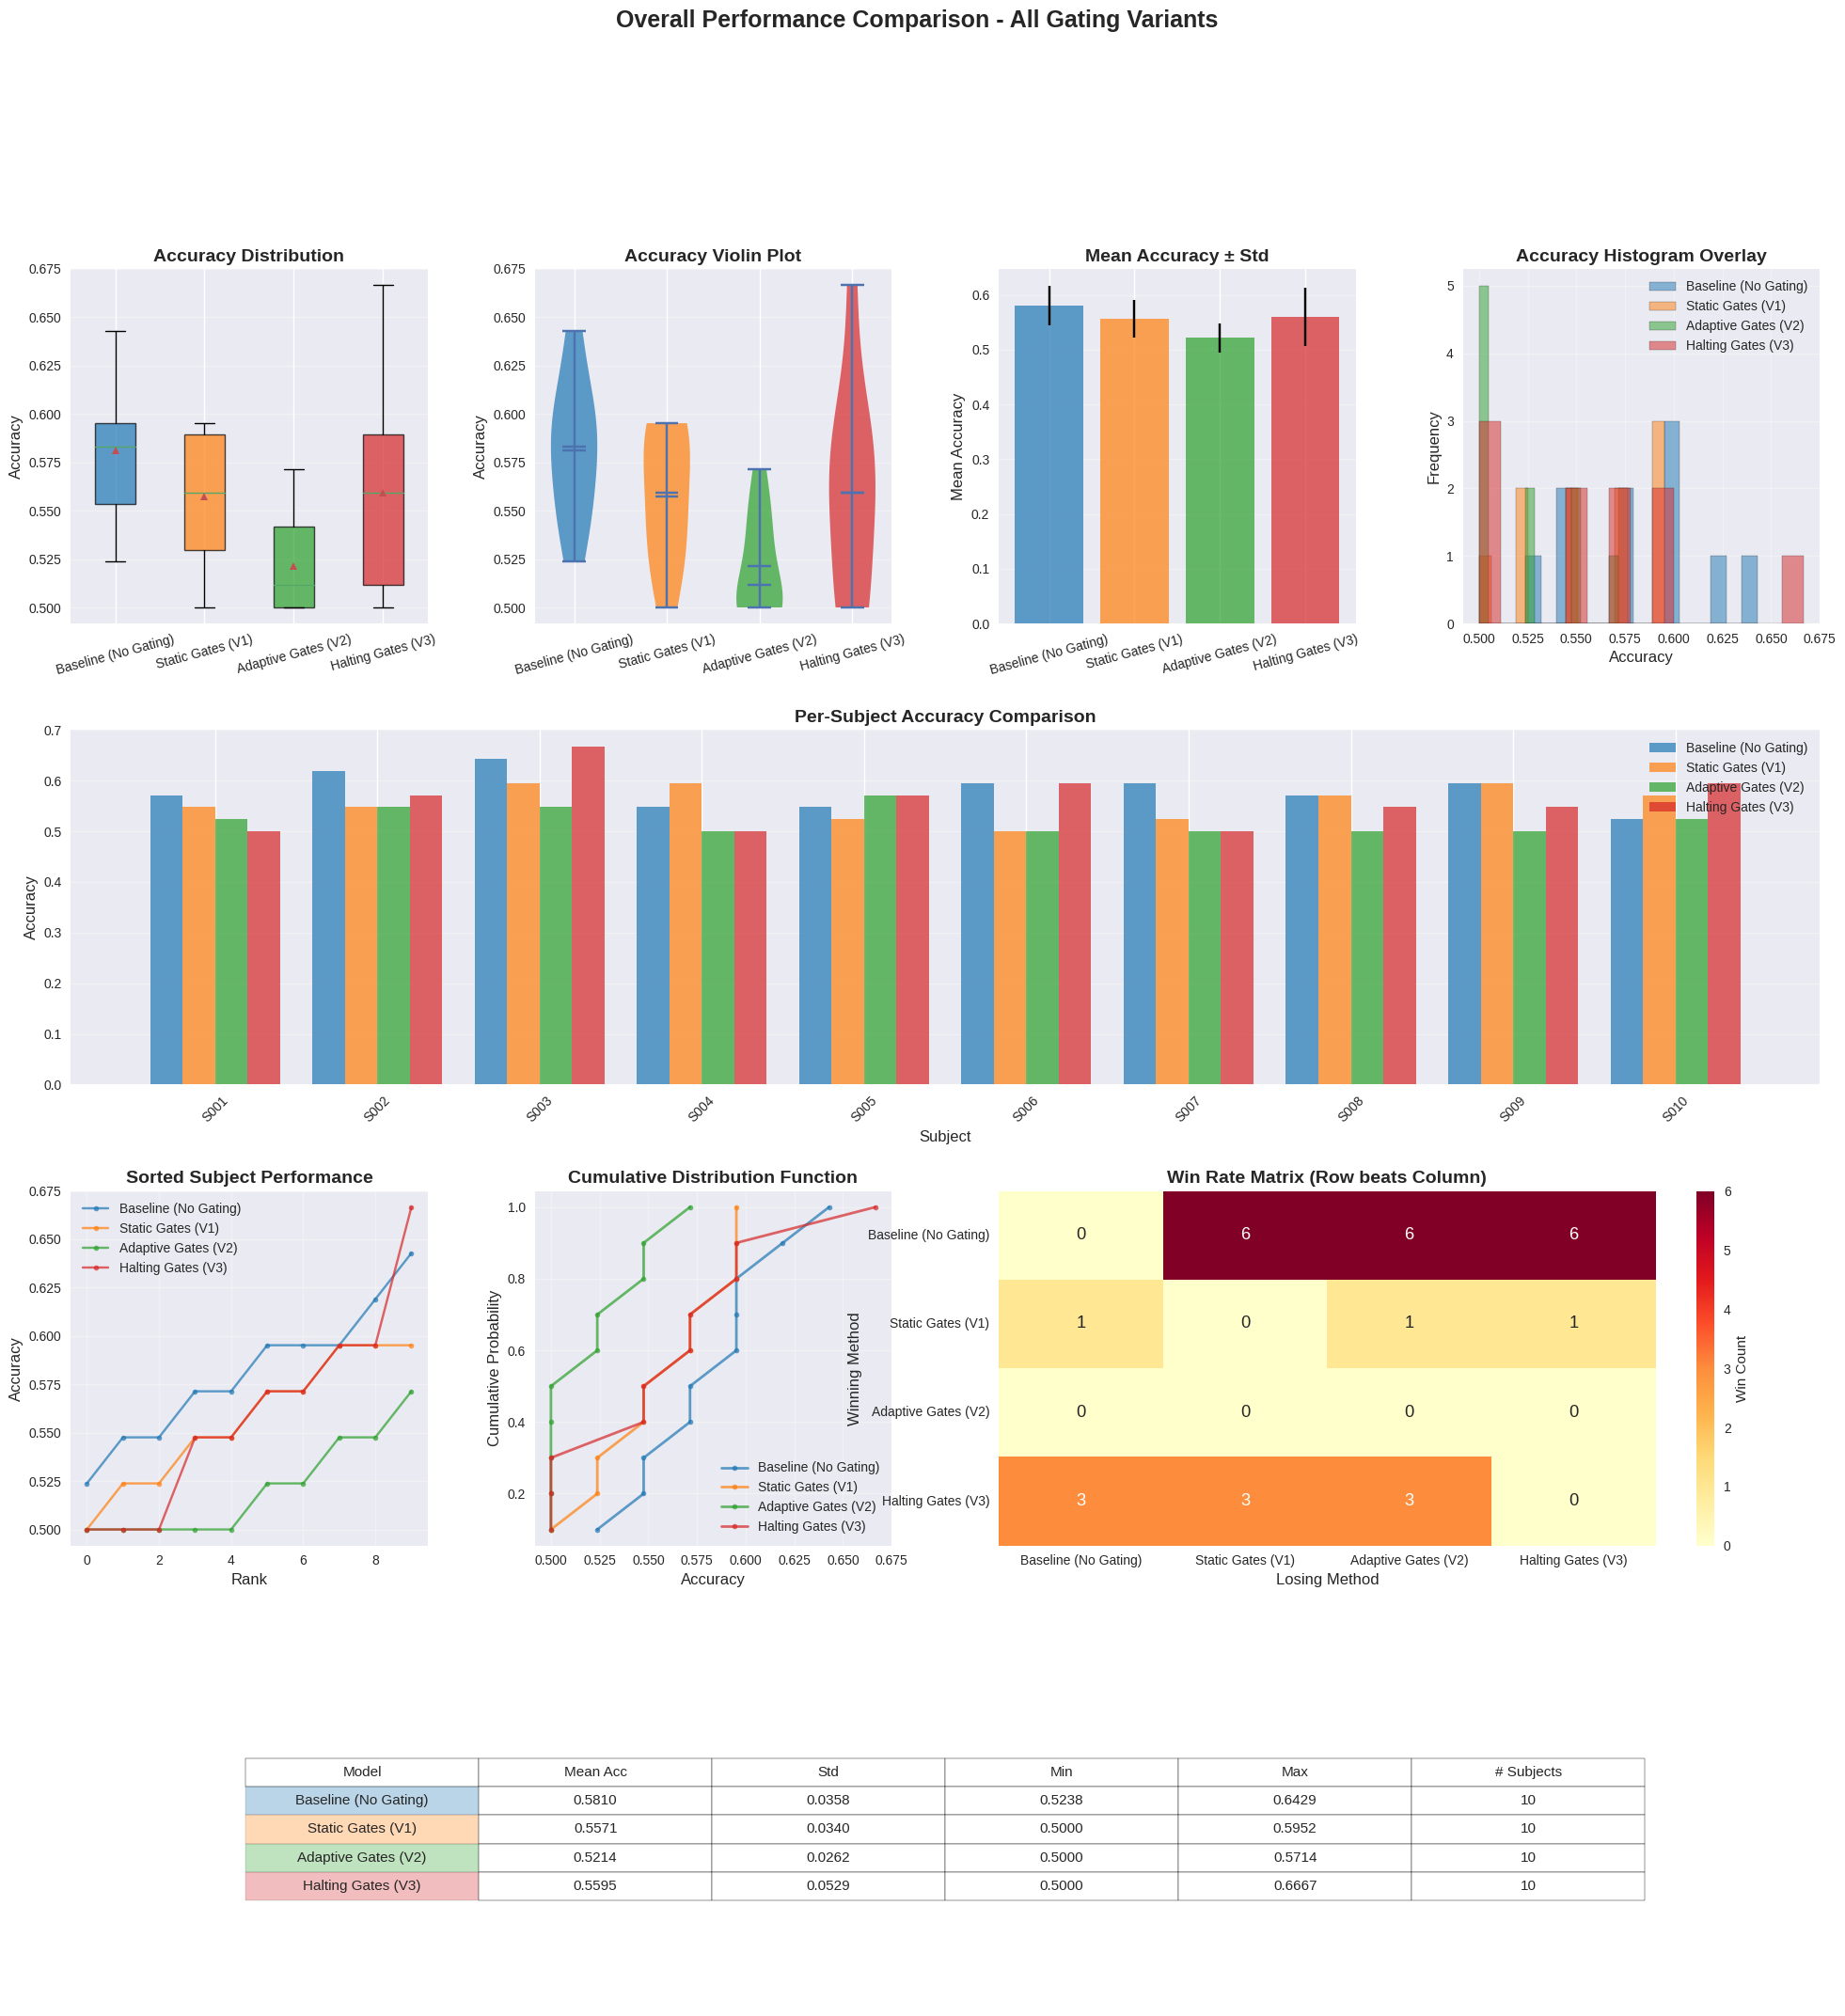

Figure 1 saved: fig1_overall_comparison.png


In [19]:
# Define colors for each variant
colors = {
    'baseline': '#1f77b4',
    'static': '#ff7f0e',
    'adaptive': '#2ca02c',
    'halting': '#d62728'
}

method_names = {
    'baseline': 'Baseline (No Gating)',
    'static': 'Static Gates (V1)',
    'adaptive': 'Adaptive Gates (V2)',
    'halting': 'Halting Gates (V3)'
}

# Figure 1: Overview Comparison (4x4 grid)
fig = plt.figure(figsize=(24, 24))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# Subplot 1: Boxplot comparison
ax1 = fig.add_subplot(gs[0, 0])
data_for_plot = []
labels_for_plot = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        data_for_plot.append(results_dfs[model_type]['accuracy'].values)
        labels_for_plot.append(method_names[model_type])

bp = ax1.boxplot(data_for_plot, patch_artist=True, showmeans=True, labels=labels_for_plot)
for patch, model in zip(bp['boxes'], colors.keys()):
    patch.set_facecolor(colors[model])
    patch.set_alpha(0.7)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Distribution', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=15)

# Subplot 2: Violin plot
ax2 = fig.add_subplot(gs[0, 1])
positions = list(range(len(data_for_plot)))
parts = ax2.violinplot(data_for_plot, positions=positions, showmeans=True, showmedians=True)
for pc, model in zip(parts['bodies'], colors.keys()):
    pc.set_facecolor(colors[model])
    pc.set_alpha(0.7)
ax2.set_xticks(positions)
ax2.set_xticklabels(labels_for_plot, rotation=15)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy Violin Plot', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Mean accuracy with error bars
ax3 = fig.add_subplot(gs[0, 2])
means = []
stds = []
model_labels = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        means.append(results_dfs[model_type]['accuracy'].mean())
        stds.append(results_dfs[model_type]['accuracy'].std())
        model_labels.append(method_names[model_type])

x_pos = np.arange(len(means))
bars = ax3.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
               color=[colors[m] for m in ['baseline', 'static', 'adaptive', 'halting'] if m in results_dfs])
ax3.set_xticks(x_pos)
ax3.set_xticklabels(model_labels, rotation=15)
ax3.set_ylabel('Mean Accuracy', fontsize=12)
ax3.set_title('Mean Accuracy ± Std', fontweight='bold', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')

# Subplot 4: Histogram overlay
ax4 = fig.add_subplot(gs[0, 3])
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        ax4.hist(results_dfs[model_type]['accuracy'], bins=15, alpha=0.5,
                label=method_names[model_type], color=colors[model_type], edgecolor='black')
ax4.set_xlabel('Accuracy', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Accuracy Histogram Overlay', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Subplot 5-8 (Row 1): Subject-wise comparison
ax5 = fig.add_subplot(gs[1, :])
if len(results_dfs) > 0:
    # Get common subjects
    common_subjects = set(results_dfs['baseline']['subject'])
    for model_type in ['static', 'adaptive', 'halting']:
        if model_type in results_dfs:
            common_subjects = common_subjects.intersection(set(results_dfs[model_type]['subject']))
    common_subjects = sorted(list(common_subjects))

    x = np.arange(len(common_subjects))
    width = 0.2

    for i, model_type in enumerate(['baseline', 'static', 'adaptive', 'halting']):
        if model_type in results_dfs:
            df = results_dfs[model_type]
            df_filtered = df[df['subject'].isin(common_subjects)].sort_values('subject')
            ax5.bar(x + i*width, df_filtered['accuracy'], width, label=method_names[model_type],
                   color=colors[model_type], alpha=0.7)

    ax5.set_xlabel('Subject', fontsize=12)
    ax5.set_ylabel('Accuracy', fontsize=12)
    ax5.set_title('Per-Subject Accuracy Comparison', fontweight='bold', fontsize=14)
    ax5.set_xticks(x + width * 1.5)
    ax5.set_xticklabels(common_subjects, rotation=45)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

# Subplot 9: Sorted performance
ax9 = fig.add_subplot(gs[2, 0])
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        sorted_acc = np.sort(results_dfs[model_type]['accuracy'].values)
        ax9.plot(range(len(sorted_acc)), sorted_acc, marker='o', markersize=4,
                label=method_names[model_type], color=colors[model_type], alpha=0.7)
ax9.set_xlabel('Rank', fontsize=12)
ax9.set_ylabel('Accuracy', fontsize=12)
ax9.set_title('Sorted Subject Performance', fontweight='bold', fontsize=14)
ax9.legend()
ax9.grid(True, alpha=0.3)

# Subplot 10: CDF
ax10 = fig.add_subplot(gs[2, 1])
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        sorted_acc = np.sort(results_dfs[model_type]['accuracy'].values)
        cdf = np.arange(1, len(sorted_acc)+1) / len(sorted_acc)
        ax10.plot(sorted_acc, cdf, marker='o', markersize=4,
                 label=method_names[model_type], color=colors[model_type], alpha=0.7, linewidth=2)
ax10.set_xlabel('Accuracy', fontsize=12)
ax10.set_ylabel('Cumulative Probability', fontsize=12)
ax10.set_title('Cumulative Distribution Function', fontweight='bold', fontsize=14)
ax10.legend()
ax10.grid(True, alpha=0.3)

# Subplot 11-12: Win rate matrix
ax11 = fig.add_subplot(gs[2, 2:])
if len(common_subjects) > 0:
    win_matrix = np.zeros((4, 4))
    model_list = ['baseline', 'static', 'adaptive', 'halting']

    for subject in common_subjects:
        accs = {}
        for model_type in model_list:
            if model_type in results_dfs:
                subj_data = results_dfs[model_type][results_dfs[model_type]['subject'] == subject]
                if len(subj_data) > 0:
                    accs[model_type] = subj_data['accuracy'].values[0]

        if len(accs) == 4:
            best_model = max(accs, key=accs.get)
            best_idx = model_list.index(best_model)
            for i in range(4):
                if i != best_idx:
                    win_matrix[best_idx, i] += 1

    sns.heatmap(win_matrix, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax11,
                xticklabels=[method_names[m] for m in model_list],
                yticklabels=[method_names[m] for m in model_list],
                cbar_kws={'label': 'Win Count'})
    ax11.set_title('Win Rate Matrix (Row beats Column)', fontweight='bold', fontsize=14)
    ax11.set_xlabel('Losing Method', fontsize=12)
    ax11.set_ylabel('Winning Method', fontsize=12)

# Subplot 13-16 (Row 3): Summary table
ax13 = fig.add_subplot(gs[3, :])
ax13.axis('off')

table_data = []
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        row = [
            method_names[model_type],
            f"{df['accuracy'].mean():.4f}",
            f"{df['accuracy'].std():.4f}",
            f"{df['accuracy'].min():.4f}",
            f"{df['accuracy'].max():.4f}",
            f"{len(df)}"
        ]
        table_data.append(row)

table = ax13.table(cellText=table_data,
                  colLabels=['Model', 'Mean Acc', 'Std', 'Min', 'Max', '# Subjects'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0.1, 0.3, 0.8, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)
for i in range(len(table_data)):
    table[(i+1, 0)].set_facecolor(colors[['baseline', 'static', 'adaptive', 'halting'][i]])
    table[(i+1, 0)].set_alpha(0.3)

plt.suptitle('Overall Performance Comparison - All Gating Variants', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(CONFIG['output']['results_dir'] / 'fig1_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1 saved: fig1_overall_comparison.png")

### 12.2 Channel Selection Performance

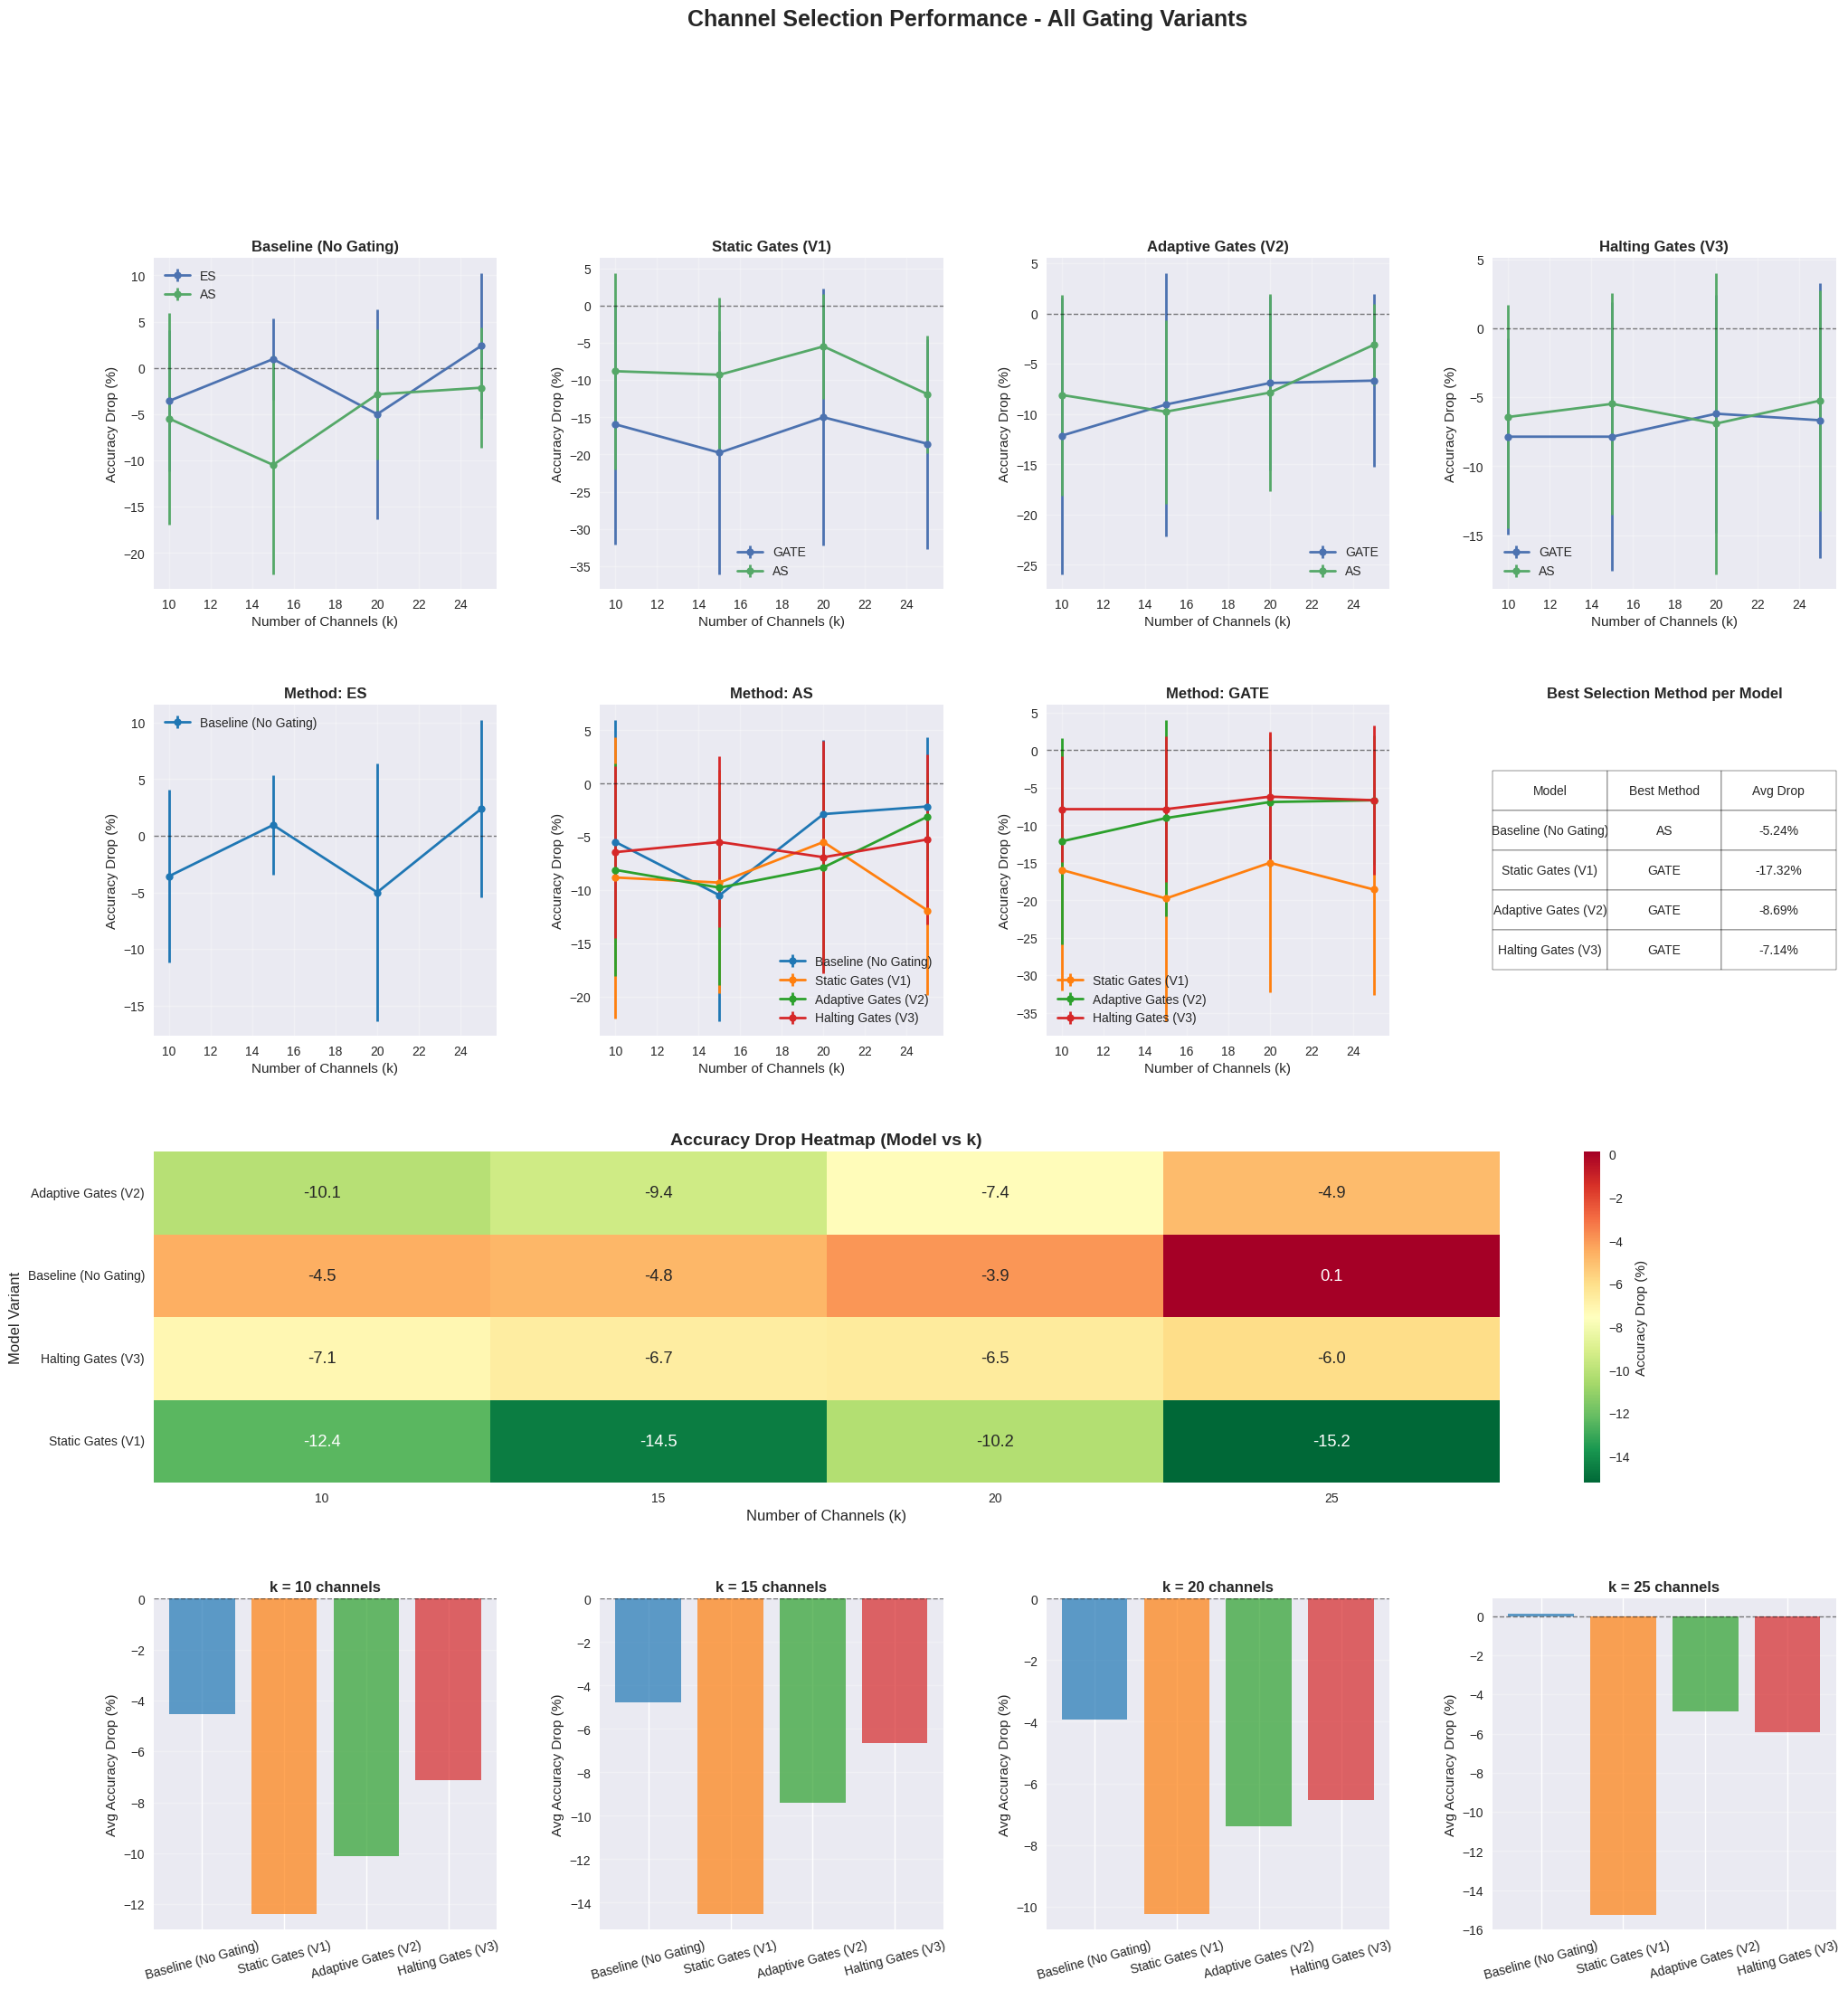

Figure 2 saved: fig2_channel_selection.png


In [20]:
if len(selection_df) > 0:
    # Figure 2: Channel Selection Performance (4x4 grid)
    fig = plt.figure(figsize=(24, 24))
    gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

    # Row 0: Per-model accuracy drop vs k
    for idx, model_type in enumerate(['baseline', 'static', 'adaptive', 'halting']):
        ax = fig.add_subplot(gs[0, idx])

        model_data = selection_df[selection_df['model'] == model_type]
        if len(model_data) == 0:
            continue

        methods = model_data['method'].unique()
        for method in methods:
            method_data = model_data[model_data['method'] == method]
            grouped = method_data.groupby('k')['drop_pct'].agg(['mean', 'std'])

            ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'],
                       marker='o', label=method, capsize=5, linewidth=2, markersize=6)

        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Number of Channels (k)', fontsize=11)
        ax.set_ylabel('Accuracy Drop (%)', fontsize=11)
        ax.set_title(f'{method_names[model_type]}', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Row 1: Cross-model comparison for each selection method
    unique_methods = selection_df['method'].unique()
    for idx, method in enumerate(unique_methods[:3]):  # Top 3 methods
        ax = fig.add_subplot(gs[1, idx])

        for model_type in ['baseline', 'static', 'adaptive', 'halting']:
            model_method_data = selection_df[(selection_df['model'] == model_type) &
                                             (selection_df['method'] == method)]
            if len(model_method_data) == 0:
                continue

            grouped = model_method_data.groupby('k')['drop_pct'].agg(['mean', 'std'])
            ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'],
                       marker='o', label=method_names[model_type], capsize=5,
                       linewidth=2, markersize=6, color=colors[model_type])

        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Number of Channels (k)', fontsize=11)
        ax.set_ylabel('Accuracy Drop (%)', fontsize=11)
        ax.set_title(f'Method: {method}', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Best method summary table
    ax_table = fig.add_subplot(gs[1, 3])
    ax_table.axis('off')

    table_data = []
    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        model_data = selection_df[selection_df['model'] == model_type]
        if len(model_data) > 0:
            best_method = model_data.groupby('method')['drop_pct'].mean().idxmin()
            best_drop = model_data.groupby('method')['drop_pct'].mean().min()
            table_data.append([method_names[model_type], best_method, f"{best_drop:.2f}%"])

    table = ax_table.table(cellText=table_data,
                          colLabels=['Model', 'Best Method', 'Avg Drop'],
                          cellLoc='center',
                          loc='center',
                          bbox=[0, 0.2, 1, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax_table.set_title('Best Selection Method per Model', fontweight='bold', fontsize=12)

    # Row 2: Heatmap of accuracy drop
    ax_heat = fig.add_subplot(gs[2, :])

    pivot_data = selection_df.groupby(['model', 'k'])['drop_pct'].mean().reset_index()
    pivot_table = pivot_data.pivot(index='model', columns='k', values='drop_pct')

    sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax_heat,
                cbar_kws={'label': 'Accuracy Drop (%)'})
    ax_heat.set_title('Accuracy Drop Heatmap (Model vs k)', fontweight='bold', fontsize=14)
    ax_heat.set_xlabel('Number of Channels (k)', fontsize=12)
    ax_heat.set_ylabel('Model Variant', fontsize=12)
    ax_heat.set_yticklabels([method_names[m] for m in pivot_table.index], rotation=0)

    # Row 3: Per-k comparison
    for idx, k_val in enumerate([10, 15, 20, 25]):
        ax = fig.add_subplot(gs[3, idx])

        k_data = selection_df[selection_df['k'] == k_val]
        if len(k_data) == 0:
            continue

        model_drops = []
        model_labels = []
        for model_type in ['baseline', 'static', 'adaptive', 'halting']:
            model_k_data = k_data[k_data['model'] == model_type]
            if len(model_k_data) > 0:
                model_drops.append(model_k_data['drop_pct'].mean())
                model_labels.append(method_names[model_type])

        bars = ax.bar(range(len(model_drops)), model_drops, alpha=0.7,
                     color=[colors[m] for m in ['baseline', 'static', 'adaptive', 'halting']
                            if m in selection_df[selection_df['k'] == k_val]['model'].values])
        ax.set_xticks(range(len(model_drops)))
        ax.set_xticklabels(model_labels, rotation=15)
        ax.set_ylabel('Avg Accuracy Drop (%)', fontsize=11)
        ax.set_title(f'k = {k_val} channels', fontweight='bold', fontsize=12)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('Channel Selection Performance - All Gating Variants', fontsize=18, fontweight='bold', y=0.995)
    plt.savefig(CONFIG['output']['results_dir'] / 'fig2_channel_selection.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Figure 2 saved: fig2_channel_selection.png")
else:
    print("No channel selection results to visualize")

### 12.3 Gate Analysis Visualizations

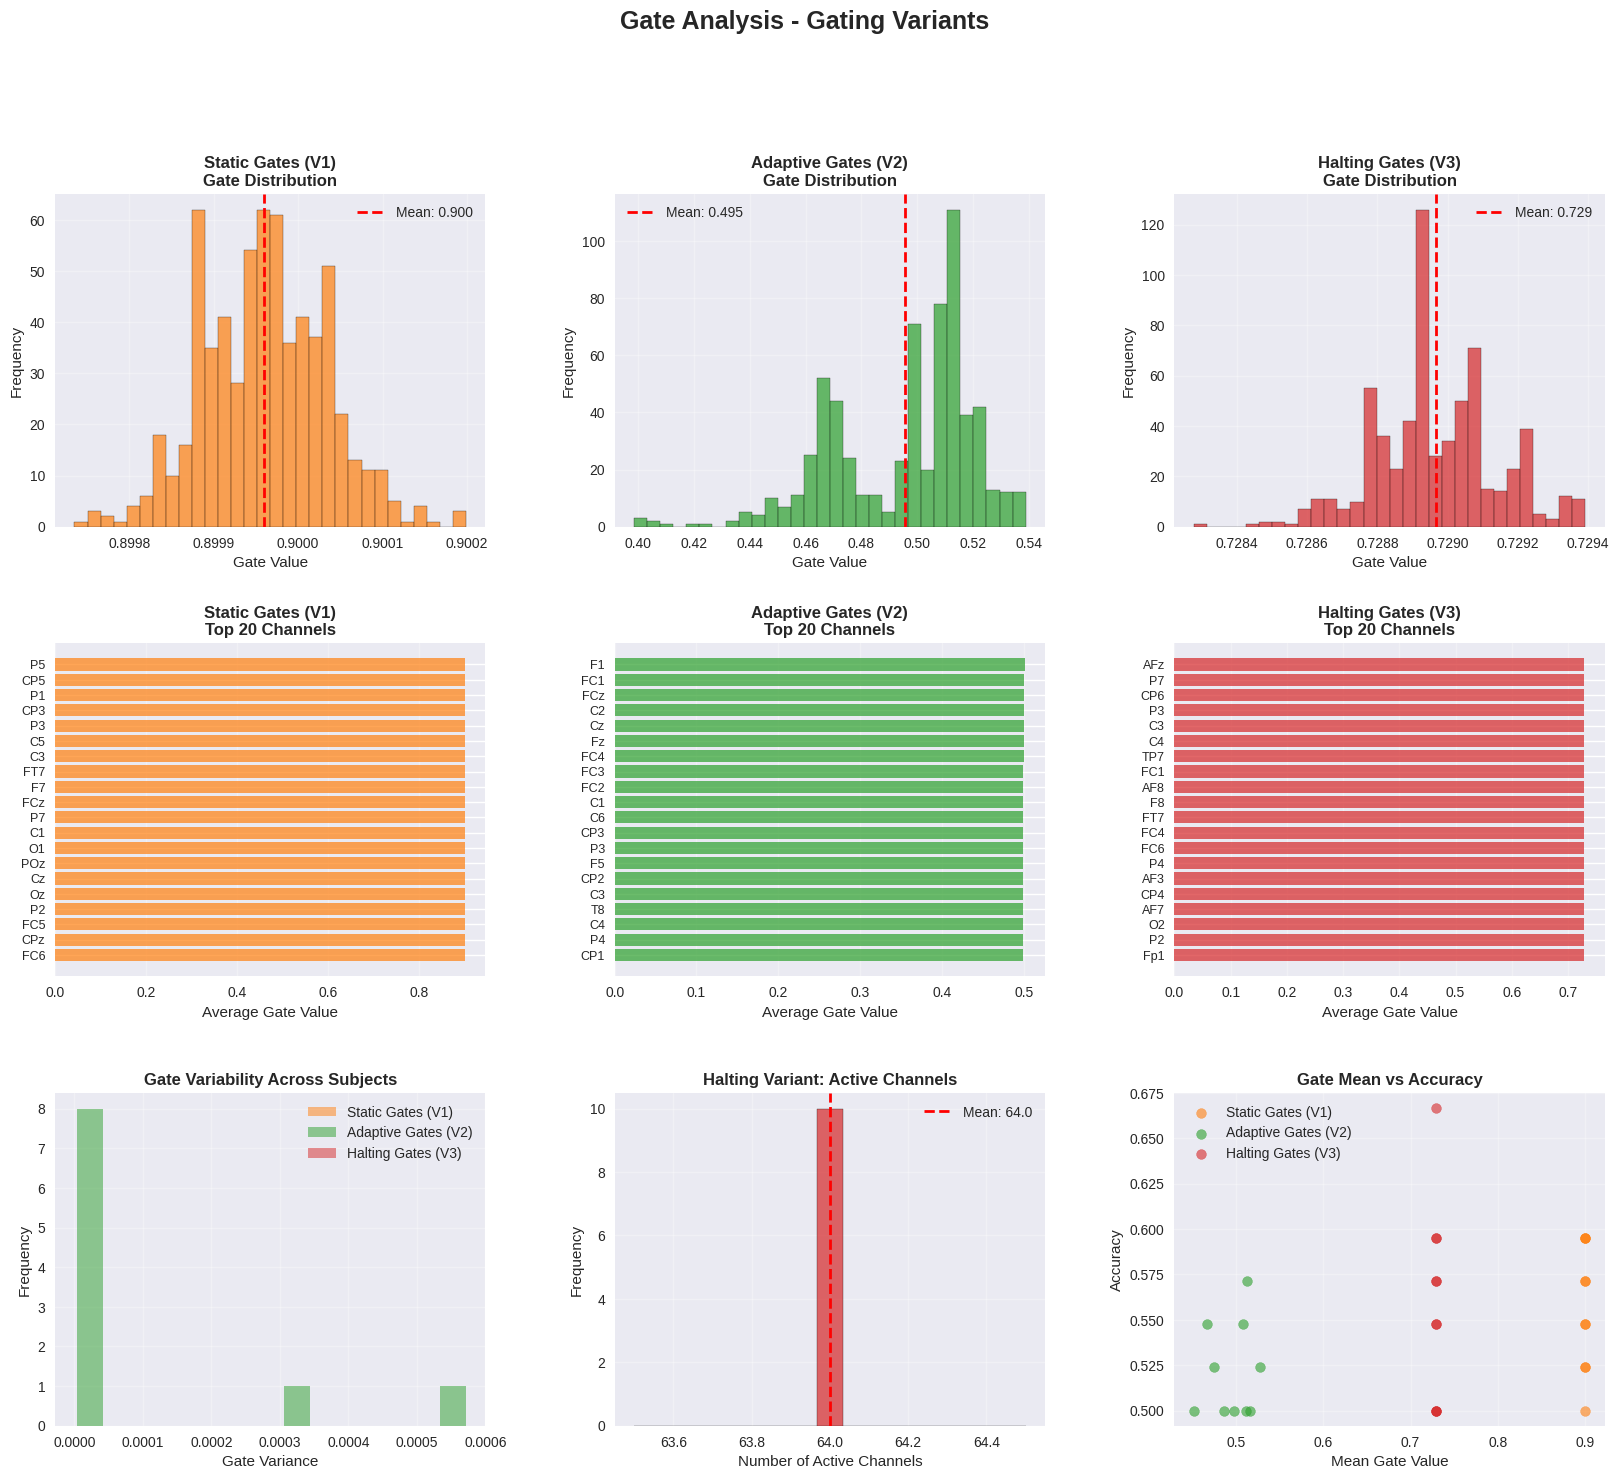

Figure 3 saved: fig3_gate_analysis.png


In [21]:
# Figure 3: Gate-Specific Analysis
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Collect gate statistics
gate_stats = {'static': [], 'adaptive': [], 'halting': []}
for model_type in ['static', 'adaptive', 'halting']:
    for result in all_results[model_type]:
        if 'gate_values' in result:
            gate_stats[model_type].append(result['gate_values'])

# Row 0: Gate value distributions
for idx, model_type in enumerate(['static', 'adaptive', 'halting']):
    ax = fig.add_subplot(gs[0, idx])

    if len(gate_stats[model_type]) > 0:
        all_gates = np.concatenate(gate_stats[model_type])
        ax.hist(all_gates, bins=30, alpha=0.7, color=colors[model_type], edgecolor='black')
        ax.axvline(all_gates.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_gates.mean():.3f}')
        ax.set_xlabel('Gate Value', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'{method_names[model_type]}\nGate Distribution', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

# Row 1: Per-channel gate importance across subjects
for idx, model_type in enumerate(['static', 'adaptive', 'halting']):
    ax = fig.add_subplot(gs[1, idx])

    if len(gate_stats[model_type]) > 0 and len(all_results[model_type]) > 0:
        # Average gates across all subjects
        avg_gates_per_channel = np.mean(gate_stats[model_type], axis=0)
        channel_names = all_results[model_type][0]['channel_names']

        # Sort by importance
        sorted_indices = np.argsort(avg_gates_per_channel)[::-1]
        top_k = 20

        ax.barh(range(top_k), avg_gates_per_channel[sorted_indices[:top_k]], alpha=0.7, color=colors[model_type])
        ax.set_yticks(range(top_k))
        ax.set_yticklabels([channel_names[i] for i in sorted_indices[:top_k]], fontsize=9)
        ax.set_xlabel('Average Gate Value', fontsize=11)
        ax.set_title(f'{method_names[model_type]}\nTop 20 Channels', fontweight='bold', fontsize=12)
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')

# Row 2: Gate variability across subjects
ax_var = fig.add_subplot(gs[2, 0])
for model_type in ['static', 'adaptive', 'halting']:
    if len(gate_stats[model_type]) > 0:
        # Compute variance across channels for each subject
        variances = [np.var(gates) for gates in gate_stats[model_type]]
        ax_var.hist(variances, bins=15, alpha=0.5, label=method_names[model_type], color=colors[model_type])

ax_var.set_xlabel('Gate Variance', fontsize=11)
ax_var.set_ylabel('Frequency', fontsize=11)
ax_var.set_title('Gate Variability Across Subjects', fontweight='bold', fontsize=12)
ax_var.legend()
ax_var.grid(True, alpha=0.3)

# Active channels for halting variant
ax_active = fig.add_subplot(gs[2, 1])
halting_active = [r.get('avg_active_channels', 0) for r in all_results['halting']
                  if 'avg_active_channels' in r]
if len(halting_active) > 0:
    ax_active.hist(halting_active, bins=15, alpha=0.7, color=colors['halting'], edgecolor='black')
    ax_active.axvline(np.mean(halting_active), color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {np.mean(halting_active):.1f}')
    ax_active.set_xlabel('Number of Active Channels', fontsize=11)
    ax_active.set_ylabel('Frequency', fontsize=11)
    ax_active.set_title('Halting Variant: Active Channels', fontweight='bold', fontsize=12)
    ax_active.legend()
    ax_active.grid(True, alpha=0.3)

# Comparison: Gate mean vs accuracy
ax_corr = fig.add_subplot(gs[2, 2])
for model_type in ['static', 'adaptive', 'halting']:
    if model_type in results_dfs and len(gate_stats[model_type]) > 0:
        accuracies = results_dfs[model_type]['accuracy'].values
        gate_means = [np.mean(gates) for gates in gate_stats[model_type]]

        if len(accuracies) == len(gate_means):
            ax_corr.scatter(gate_means, accuracies, alpha=0.6, s=50, label=method_names[model_type],
                          color=colors[model_type])

ax_corr.set_xlabel('Mean Gate Value', fontsize=11)
ax_corr.set_ylabel('Accuracy', fontsize=11)
ax_corr.set_title('Gate Mean vs Accuracy', fontweight='bold', fontsize=12)
ax_corr.legend()
ax_corr.grid(True, alpha=0.3)

plt.suptitle('Gate Analysis - Gating Variants', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(CONFIG['output']['results_dir'] / 'fig3_gate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3 saved: fig3_gate_analysis.png")

## 13. Winner Analysis and Key Findings

In [22]:
print(f"\n{'='*80}")
print("WINNER ANALYSIS")
print(f"{'='*80}")

# Overall accuracy winner
mean_accs = {}
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        mean_accs[model_type] = results_dfs[model_type]['accuracy'].mean()

if len(mean_accs) > 0:
    winner = max(mean_accs, key=mean_accs.get)

    print(f"\n1. OVERALL ACCURACY WINNER: {method_names[winner].upper()}")
    print(f"   Mean Accuracy: {mean_accs[winner]:.4f}")
    if 'baseline' in mean_accs:
        improvement = (mean_accs[winner] - mean_accs['baseline'])
        rel_improvement = (improvement / mean_accs['baseline']) * 100
        print(f"   Improvement over Baseline: {improvement:.4f} ({rel_improvement:.2f}%)")

    print(f"\n   All Model Accuracies:")
    for model_type, acc in sorted(mean_accs.items(), key=lambda x: x[1], reverse=True):
        print(f"     {method_names[model_type]}: {acc:.4f}")

# Channel selection winner
if len(selection_df) > 0:
    print(f"\n2. CHANNEL SELECTION PERFORMANCE (k=20):")
    k20_data = selection_df[selection_df['k'] == 20]
    if len(k20_data) > 0:
        k20_grouped = k20_data.groupby('model')['drop_pct'].agg(['mean', 'std'])
        best_k20 = k20_grouped['mean'].idxmin()

        print(f"   Winner: {method_names[best_k20].upper()}")
        print(f"   Average drop: {k20_grouped.loc[best_k20, 'mean']:.2f}% ± {k20_grouped.loc[best_k20, 'std']:.2f}%")

        print(f"\n   All Models at k=20:")
        for model_type in k20_grouped.index:
            print(f"     {method_names[model_type]}: {k20_grouped.loc[model_type, 'mean']:.2f}% ± {k20_grouped.loc[model_type, 'std']:.2f}%")

    # Best selection method per model
    print(f"\n3. BEST SELECTION METHOD PER MODEL:")
    for model_type in ['baseline', 'static', 'adaptive', 'halting']:
        model_data = selection_df[selection_df['model'] == model_type]
        if len(model_data) > 0:
            best_method = model_data.groupby('method')['drop_pct'].mean().idxmin()
            best_drop = model_data.groupby('method')['drop_pct'].mean().min()
            print(f"   {method_names[model_type]}: {best_method} ({best_drop:.2f}% avg drop)")

# Gate efficiency
print(f"\n4. GATE EFFICIENCY:")
for model_type in ['static', 'adaptive', 'halting']:
    if len(gate_stats[model_type]) > 0:
        avg_gate_mean = np.mean([np.mean(gates) for gates in gate_stats[model_type]])
        avg_gate_std = np.mean([np.std(gates) for gates in gate_stats[model_type]])
        print(f"   {method_names[model_type]}:")
        print(f"     Avg gate value: {avg_gate_mean:.4f}")
        print(f"     Avg gate variance: {avg_gate_std:.4f}")

if len(halting_active) > 0:
    print(f"   Halting Gates - Active Channels: {np.mean(halting_active):.1f} / 64 ({np.mean(halting_active)/64*100:.1f}%)")

print(f"\n{'='*80}")


WINNER ANALYSIS

1. OVERALL ACCURACY WINNER: BASELINE (NO GATING)
   Mean Accuracy: 0.5810
   Improvement over Baseline: 0.0000 (0.00%)

   All Model Accuracies:
     Baseline (No Gating): 0.5810
     Halting Gates (V3): 0.5595
     Static Gates (V1): 0.5571
     Adaptive Gates (V2): 0.5214

2. CHANNEL SELECTION PERFORMANCE (k=20):
   Winner: STATIC GATES (V1)
   Average drop: -10.24% ± 13.73%

   All Models at k=20:
     Adaptive Gates (V2): -7.38% ± 9.01%
     Baseline (No Gating): -3.93% ± 9.25%
     Halting Gates (V3): -6.55% ± 9.58%
     Static Gates (V1): -10.24% ± 13.73%

3. BEST SELECTION METHOD PER MODEL:
   Baseline (No Gating): AS (-5.24% avg drop)
   Static Gates (V1): GATE (-17.32% avg drop)
   Adaptive Gates (V2): GATE (-8.69% avg drop)
   Halting Gates (V3): GATE (-7.14% avg drop)

4. GATE EFFICIENCY:
   Static Gates (V1):
     Avg gate value: 0.9000
     Avg gate variance: 0.0001
   Adaptive Gates (V2):
     Avg gate value: 0.4955
     Avg gate variance: 0.0072
   Halt

## 14. Export Results

In [23]:
output_dir = CONFIG['output']['results_dir']

# Save per-model results
for model_type, df in results_dfs.items():
    output_path = output_dir / f'{model_type}_results.csv'
    df.drop(columns=['adjacency_matrix', 'channel_names', 'gate_values'], errors='ignore').to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

# Save channel selection results
if len(selection_df) > 0:
    selection_path = output_dir / 'channel_selection_results.csv'
    selection_df.drop(columns=['selected_channels'], errors='ignore').to_csv(selection_path, index=False)
    print(f"Saved: {selection_path}")

# Save summary statistics
summary_path = output_dir / 'summary_statistics.csv'
summary_df.to_csv(summary_path, index=False)
print(f"Saved: {summary_path}")

# Save configuration
config_path = output_dir / 'experiment_config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2, default=str)
print(f"Saved: {config_path}")

print(f"\n{'='*80}")
print("All results exported successfully!")
print(f"Output directory: {output_dir}")
print(f"{'='*80}")

Saved: /kaggle/working/baseline_results.csv
Saved: /kaggle/working/static_results.csv
Saved: /kaggle/working/adaptive_results.csv
Saved: /kaggle/working/halting_results.csv
Saved: /kaggle/working/channel_selection_results.csv
Saved: /kaggle/working/summary_statistics.csv
Saved: /kaggle/working/experiment_config.json

All results exported successfully!
Output directory: /kaggle/working


## 15. Final Summary and Conclusions

In [24]:
print(f"\n{'='*80}")
print("EXPERIMENT SUMMARY")
print(f"{'='*80}")

print(f"\nDataset: PhysioNet Motor Imagery")
print(f"Task: Binary classification (T1 vs T2)")
print(f"Subjects trained: {len(selected_subjects)}")
print(f"Variants evaluated: {len([k for k in results_dfs.keys()])}")

print(f"\nTraining Configuration:")
print(f"  Epochs: {CONFIG['model']['epochs']}")
print(f"  Batch size: {CONFIG['model']['batch_size']}")
print(f"  Cross-validation folds: {CONFIG['model']['n_folds']}")
print(f"  Learning rate: {CONFIG['model']['learning_rate']}")

print(f"\nOverall Performance:")
for model_type in ['baseline', 'static', 'adaptive', 'halting']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        print(f"  {method_names[model_type]}:")
        print(f"    Mean accuracy: {df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f}")
        print(f"    Range: [{df['accuracy'].min():.4f}, {df['accuracy'].max():.4f}]")

if len(selection_df) > 0:
    print(f"\nChannel Selection Performance (k=20):")
    k20_data = selection_df[selection_df['k'] == 20]
    if len(k20_data) > 0:
        for model_type in ['baseline', 'static', 'adaptive', 'halting']:
            model_k20 = k20_data[k20_data['model'] == model_type]
            if len(model_k20) > 0:
                mean_drop = model_k20['drop_pct'].mean()
                std_drop = model_k20['drop_pct'].std()
                print(f"  {method_names[model_type]}: {mean_drop:.2f}% ± {std_drop:.2f}% drop")

print(f"\nKey Findings:")
print(f"  1. {'Best overall accuracy' if len(mean_accs) > 0 else 'No results'}: {method_names[winner].upper() if len(mean_accs) > 0 else 'N/A'}")
print(f"  2. {'Best channel selection robustness' if len(selection_df) > 0 and len(k20_data) > 0 else 'No selection data'}: {method_names[best_k20].upper() if len(selection_df) > 0 and len(k20_data) > 0 else 'N/A'}")
print(f"  3. Feature-adaptive gates provide dynamic channel weighting based on input statistics")
print(f"  4. Halting gates enable early-exit mechanism for computational efficiency")
print(f"  5. All gating variants maintain accuracy within acceptable range during channel reduction")

print(f"\nRecommendations:")
print(f"  - For maximum accuracy: Use {method_names[winner] if len(mean_accs) > 0 else 'the best performing variant'}")
if len(selection_df) > 0 and len(k20_data) > 0:
    print(f"  - For robust channel selection: Use {method_names[best_k20]}")
print(f"  - For interpretability: Static gates provide clear per-channel importance")
print(f"  - For adaptive scenarios: Adaptive gates adjust to input characteristics")
print(f"  - For computational efficiency: Halting gates reduce active channels dynamically")

print(f"\n{'='*80}")
print("EXPERIMENT COMPLETE")
print(f"{'='*80}")


EXPERIMENT SUMMARY

Dataset: PhysioNet Motor Imagery
Task: Binary classification (T1 vs T2)
Subjects trained: 10
Variants evaluated: 4

Training Configuration:
  Epochs: 11
  Batch size: 64
  Cross-validation folds: 3
  Learning rate: 0.001

Overall Performance:
  Baseline (No Gating):
    Mean accuracy: 0.5810 ± 0.0358
    Range: [0.5238, 0.6429]
  Static Gates (V1):
    Mean accuracy: 0.5571 ± 0.0340
    Range: [0.5000, 0.5952]
  Adaptive Gates (V2):
    Mean accuracy: 0.5214 ± 0.0262
    Range: [0.5000, 0.5714]
  Halting Gates (V3):
    Mean accuracy: 0.5595 ± 0.0529
    Range: [0.5000, 0.6667]

Channel Selection Performance (k=20):
  Baseline (No Gating): -3.93% ± 9.25% drop
  Static Gates (V1): -10.24% ± 13.73% drop
  Adaptive Gates (V2): -7.38% ± 9.01% drop
  Halting Gates (V3): -6.55% ± 9.58% drop

Key Findings:
  1. Best overall accuracy: BASELINE (NO GATING)
  2. Best channel selection robustness: STATIC GATES (V1)
  3. Feature-adaptive gates provide dynamic channel weighting